In [32]:
import scipy
import numpy as np
import pandas as pd
import itertools as it

from math import sin
import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import scale

from scipy.stats.stats import pearsonr 

from scipy.stats import invgamma 
from scipy.stats import beta

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

from sklearn.metrics import silhouette_samples, silhouette_score


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)


## Modular genome simulation

The functions in this directory serve to construct synthetic genomic data following user-specified parameters.

Parameters include:

- Number of populations and sample sizes.
- Local genetic distances between sources of genetic diversity.
- Population specific admixture probabilities and recombination map.

This jupyter notebook serves as a tutorial to interact with the functions that control the parameters 
available. Development of these items is open ended. To the best of my abilities they are constructed
to be modular so that new functions can be created and appended.

**context**

The development of this software is directed at providing known-truth data sets to test approaches seeking to summarize or describe local genomic data in a population genetics context. The goal is to improve comparison among approaches through
standardized data sets encompassing a variety of situations (Lotterhos et al. 2018). 


## Index

- **I.** Model local genomic structure
- **II.** Recombination map
- **III.** Admixture probabilities
- **IV.** Preparing simulation
- **V.** Simulation
- **VI.** Simulation output: Summary analysis
    - **A.** Population Genetic Structure
    - **B.** Ideogram representation of known-truth: sampling source of each known haplotype
    - **C.** KDE classification of local haplotypes
- **VII.** Output Simulation.
    - **A.** LAMP Output
    - **B.** Geno and plink output - KDE_Galaxy format
    - **C.** Loter


### I. Model local genomic structure

Populations are modelled as multivariate Beta variables. Individual values are taken
to represent binomial probabilities of observing one allele at a given site.

In order to manipulate genetic structure we first create a data set of randomly generated Beta vectors. The function `scipy.stats.beta` is used ([beta doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html)). Then, using PCA, we project the vectors onto a space where euclidian distances are roughly equal to the similarity between two vectors. This allows us to manipulate these distances directly - a much easier task than to try to model similar frequency vectors (**notebook 1**).

Genomes will be simulated as contiguous windows of same number of SNPs. This is because the relation between *Fst* and 
euclidian distance is stable for a given number of markers (see **doc. Euc to Fst**).

**References**
- Lotterhos KE, Moore JH, Stapleton AE. 2018. Analysis validation has been neglected in the Age of Reproducibility. PLOS Biol 16: e3000070. https://doi.org/10.1371/journal.pbio.3000070.

**Notebooks**
- see [Notebook 1. Generating Haplotypes](https://nbviewer.jupyter.org/github/SantosJGND/Genetic-data-analysis/blob/master/Notebooks/1.%20Generating_haplotypes.ipynb) for more details on generating and using data sets of frequency vectors.

- see [doc. Euclidian to Fst]() for a description of the relation between Fst and Euc distances in PCA space. This notebook also introduces functions to use this relation for prediction.


In [2]:
from synth_tools.Generate_freq_vectors import generate_vectors_Beta

L= 150 # number of markers for each window.
n= 100 # number of vectors produced for each combination of Beta parameters.

rangeA= [1,2.5] # range of parameter a (beta).
rangeB = [.1,.6] # range of parameter b (beta).
steps= 20 # steps along ranges.

n_comp = L # components to keep during PCA of vector data set.

vector_lib= generate_vectors_Beta(L,n,rangeA,rangeB,steps,n_comp)

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized').fit(vector_lib)
features = pca.transform(vector_lib)

print(features.shape)
print(vector_lib.shape)

(2000, 150)
(2000, 150)


#### Structure Priors

Structure prior functions take a **set of frequency vectors** and a **proxy genomic position** and return a modified set of 
vectors.

The manipulation of genetic structure produced relies on the average *Fst* between frequency vectors produced by the function `generate_vectors_Beta`, which stands around 0.1 (**notebook 1 - Fig. 5**), and on the quasi-linear relation between vector projections (*not samples*) in PCA space and *Fst* (**notebook 6**).


- [6. A link to Fst](https://nbviewer.jupyter.org/github/SantosJGND/Genetic-data-analysis/blob/master/Notebooks/6.%20A%20link%20to%20FSTs.ipynb)
describes the use of PCA to organise allele frequency vectors by genetic proximity, as measured in *Fst*.

#### Example prior function

In [3]:
def introgression_prior(coords,angle,range_windows,target= [0,1],region= [0,1],passport= False):
    '''
    Use the same vector for two populations at a given region.
    - coords: frequency vector set. (k * L).
    - angle: position along synth range.
    - range_windows: synth range.
    - region: span of differentiation pattern in prop to range provided.
    '''
    ID= 'introgression'
    progress= (angle - range_windows[0]) / (range_windows[1] - range_windows[0])
    
    if progress >= region[0] and progress <= region[1]:
        coords[target[0]] = coords[target[1]]
    
    if passport:
        return coords,ID
    else:
        return coords



Structure prior functions are stored in the script `Structure_priors.py`.

The next block displays how each function impacts pairwise *Fst*s along a synthetic genomic range.

Aside from the **coords**, **angle** and **range_windows** positional arguments, each function allows a set of keyword arguments that determine the characteristics of pattern produced.

In [4]:
from synth_tools.Structure_priors import *
from synth_tools.Tutorial_subplots import Struct_subplots_lib

Struct_lib= {
    'sinusoid':{
        'prior_func': sin_prior,
        'prior_kwargs': {
            'fst_max': 0.2,
            'target': [0,1],
            'freq': 10
        }
    },
    'linear':{
        'prior_func': linear_prior,
        'prior_kwargs': {
            'slope': -1,
            'region': [.4,.7],
            'target': [0,1]
        }
    },
    'introgression': {
        'prior_func': introgression_prior,
        'prior_kwargs': {
            'region': [.3,.4]
        }
    },
    'alien_I': {
        'prior_func': alien_prior_I,
        'prior_kwargs': {
            'fst': 0.2,
            'region': [.3,.4],
            'target': [0,1]
        }
    },
    'alien_II': {
        'prior_func': alien_prior_II,
        'prior_kwargs': {
            'fst': 0.2,
            'region': [.3,.4],
            'target': [0,1]
        }
    },
    'alien_III': {
        'prior_func': alien_prior_III,
        'prior_kwargs': {
            'fst_a': 0,
            'fst_b': .2,
            'region': [.3,.4],
            'target': [0,1]
        }
    }
}

#####

Struct_subplots_lib(Struct_lib,vector_lib,Npops= 3,range_diff= [0,100],xaxis= '',yaxis= 'fst')


['sinusoid', 'linear', 'introgression', 'alien_I', 'alien_II', 'alien_III']
This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\Simulate_genomes\StructE_tools.py:398: RuntimeWarning:

invalid value encountered in double_scalars



Using the display above we decide on a prior function.


We now have our populations. These are not yet represented by any samples. They are best considered as sources of genetic diversity. Next we will produce samples. we could stick to simply produce samples from each vector, but we can 
go a bit further. We will define population specific recombination maps and admixture probabilities.

**Local concepts** 

- Recombination map: defines the probability that a switch of population source occured at a given point.
- Admixture probability: Probability of the direction of the switch in population source.


### II. Recombination map

let's begin with the simpler of the two: recombination map. we will make this a function of the progression of our window along our proxy genome range.

**Example recombination prior**

In [5]:

def Rec_prob_modal(angle,range_windows,modes,multiplier,N= 100,bandwidth= .2):
    '''
    Modal recombination rate. Select location of each mode in proportion to the range given ([0,1]).
    Distribution is constructed using KDE of values given.
    - modes: position of modes. vector. 
    - N= 100: number of samples for KDE estimation.
    - bandwidth: bandwidth of KDE estimation.
    - multiplier: multiply by a given factor.
    '''
    ID= 'modal. modes: {}'.format(modes)
    N_modes= len(modes)
    progress= (angle - range_windows[0]) / (range_windows[1] - range_windows[0])
    
    sam= np.repeat(modes,N)
    sam= np.array(sam).reshape(-1,1)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sam)
    
    log_dens = kde.score_samples(progress)
    
    Cop= np.exp(log_dens)[0] * multiplier
    #print(Cop)
    return Cop, ID



Recombination priors are stored in the script `Recombination_tools.py`.

The next block displays available functions of recombination by proxy genomic position.

Like structure priors, Rec functions take two position arguments, **angle** and **range_windows**, and a set of function specific keyword arguments that determine the characteristics of patterns produced.

In [8]:
from synth_tools.Recombination_tools import *
from synth_tools.Tutorial_subplots import Rec_subplots_lib

#####
Cop_lib= {
    'uniform':{
        'cop_func': Rec_prob_uniform,
        'cop_kwargs': {
            'Cop': 1e-3
        }
    },
    'sinusoid': {
        'cop_func': Rec_prob_sinusoid,
        'cop_kwargs': {
            'multiplier': .8,
            'freq': 3,
            'c': 2
        }
    },
    'modal': {
        'cop_func': Rec_prob_modal,
        'cop_kwargs': {
            'modes': [.2,.5,.7],
            'N':100,
            'bandwidth': 0.07,
            'multiplier': 3e-2
        }
    },
    'region': {
        'cop_func': Rec_prob_region,
        'cop_kwargs': {
            'region': [.4,.6],
            'prob_basal': 0,
            'prob':.2
        }
    },
    'rdist': {
        'cop_func': Rec_prob_rdist,
        'cop_kwargs': {
            'multiplier': float(1 / 6),
            'c': .9,
            'loc': 0,
            'scale': 1
        }
    }
}

#####

    
Rec_subplots_lib(Cop_lib,vector_lib,Npops= 4,Ncols= 2,range_diff= [0,100],steps= 100,yaxis= 'Rec prob')

['uniform', 'sinusoid', 'modal', 'region', 'rdist']
This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\scipy\stats\_continuous_distns.py:4841: RuntimeWarning:

divide by zero encountered in power



### III. Admixture probabilities.

The recombination variable subject to the above functions controls the probability that a choice will be
made between sources of new samples at a given window.

Here we define the chances of sampling from each population if the choice to sample is made. For the sake of simplicity, and risking some confusion in terms, we will make use of the admixture proportions of a structure analysis using sNMF (Frichot et al. 2014).

For the moment, probabilities of Admixture are determined to remain uniform across windows.


**help**

If the recombination variable is regarded as the probability of *historical recombination*, i.e. the probability that crossing over occured at a given site in the past, then the *admixture probability* would roughly equate the proportion of times the ancestors of an individual crossed with material from a given source. 

**References**

- Frichot E, Mathieu F, Trouillon T, Bouchard G, François O. 2014. Fast and efficient estimation of individual ancestry coefficients. [Genetics 196: 973–983](http://www.genetics.org/content/196/4/973.short).


In [9]:
### Reading the sNMF output, and classing according to an inclusion threshold.

from synth_tools.Generate_samples import OriginbySNMF
inclusion_threshold= .8

Geno_Q = "Complementary_data/sNMF_output.Q"
Geneo, Ind_admx = OriginbySNMF(Geno_Q,inclusion_threshold)

#####
from synth_tools.Tutorial_subplots import Admixture_subplots_lib

Admixture_subplots_lib(Geneo,Ncols= 2,xaxis= '',yaxis= 'Admx prop',title= '')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



### IV. Preparing simulation.

Set the number of genetic sources to simulate and decide on the number of windows we will be producing.

- **Sizes**: number of samples for each pop.
- **steps**: number of windows to generate.


In [10]:

Sizes= [100,100,100,100]
steps= 200

Npops= len(Sizes)
range_diff= [0,steps]


Using the index of the populations as label, assign to each population a recombination map and a distribution of admixture probability. Admixture vectors will be sampled from those within the assigned group with replacement.

In [11]:
# recombination map
Cop_choice= {
    0:{
        'cop_func': Rec_prob_uniform,
        'cop_kwargs': {
            'Cop': 5e-2
        }
    },
    1:{
        'cop_func': Rec_prob_uniform,
        'cop_kwargs': {
            'Cop': 5e-2
        }
    },
    2:{
        'cop_func': Rec_prob_uniform,
        'cop_kwargs': {
            'Cop': 5e-2
        }
    },
    3:{
        'cop_func': Rec_prob_modal,
        'cop_kwargs': {
            'modes': [.2,.5,.7],
            'N':100,
            'bandwidth': 0.07,
            'multiplier': 4e-2
        }
    }
}

# Admixture dist.
snmf_sim= {
    0:0,
    1:1,
    2:2,
    3:4
}

In [12]:
## Organize group and individual labels and pointers.

from random import sample

Origins= {x: np.random.choice(range(len(Geneo[snmf_sim[x]])), Sizes[x], replace= True) for x in snmf_sim.keys()}
Origins= {x: sorted([Geneo[snmf_sim[x]][y] for y in Origins[x]]) for x in Origins.keys()}
Origins= {x: {y:Origins[x][y] for y in range(len(Origins[x]))} for x in Origins.keys()}

labels= [x for x in range(len(Geneo.keys())-1)]
#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}
label_vector= []
d= 0

for gp in Origins.keys():
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        label_vector.append(gp)
        d += 1

label_package= {
    'labels':labels,
    'Whose': Whose,
    'ind_to_group': ind_to_group,
    'label_vector': label_vector
}

**Local structure** Chose a pattern of local genetic structure from among those available.

In [14]:
from synth_tools.Generate_samples import Check_Path, plot_GenFst, return_fsts2

## Select struct prior function and kwargs
prior_func= introgression_prior

prior_kwargs= {
    'region': [.2,.5],
    'target': [0,2]
}


fig, Pops, prior= Check_Path(Npops,vector_lib,prior_func,prior_kwargs,Pops= [],random= True,n_comp= L,range_diff= range_diff,steps= steps)

iplot(fig)

C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\Simulate_genomes\StructE_tools.py:398: RuntimeWarning:

invalid value encountered in double_scalars



### V. Simulations.

Generate samples according to specifications.

In [15]:
########
########
from synth_tools.Generate_samples import Gen_samples_II

window_size= 5e3
Chr= 1

Windows, Fst_windows, Ideo, Out= Gen_samples_II(Pops,Sizes,vector_lib,label_package,Origins,prior_func,prior_kwargs,Cop_choice,window_size= window_size,Chr= Chr,range_diff=range_diff)

...


C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\Simulate_genomes\StructE_tools.py:398: RuntimeWarning:

invalid value encountered in double_scalars



Done.


### VI. Simulation output: Summary analysis

#### A. Population genetic structure

Perform PCA on simulated haplotypes concatenated across windows.

In [57]:
#### ###

Haplotypes= np.concatenate(tuple([Windows[1][x] for x in Windows[1].keys()]), axis=1)

print('Number of markers: {}'.format(Haplotypes.shape[1]))

print('Number of individuals: {}'.format(Haplotypes.shape[0]))

pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')

feats= pca2.fit_transform(Haplotypes)

coords= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in list(set(label_vector))}

##

## perform MeanShift clustering.
bandwidth = estimate_bandwidth(feats, quantile=0.25)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=False, min_bin_freq=35)
ms.fit(feats)
labels1 = ms.labels_
label_select = {y:[x for x in range(len(labels1)) if labels1[x] == y] for y in sorted(list(set(labels1)))}

##

PCA_color_ref= ['darkseagreen','crimson', 'cyan', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink']

from plotly import tools

fig_pca_subplots = tools.make_subplots(rows=2, cols=2)

for subp in range(4):
    
    n_plot= subp
    
    if subp >= 2:
        coords= label_select
        subp -= 2
        Col_vec= PCA_color_ref
        
    else:
        Col_vec= ['red','yellow','blue','purple','green']
    
    
    for i in coords.keys():
        trace= go.Scatter(
        x = feats[coords[i],0],
        y = feats[coords[i],subp + 1],
        mode= "markers",
        name= str(i),
        marker= {
        'color': Col_vec[i],
        'line': {'width': 0},
        'size': 6,
        'symbol': 'circle',
        "opacity": .8})
        
        fig_pca_subplots.append_trace(trace, int(n_plot/float(2)) + 1, subp + 1)
    
    fig_pca_subplots['layout']['yaxis' + str(n_plot + 1)].update(title='PC{}'.format(subp + 2))
    fig_pca_subplots['layout']['xaxis' + str(n_plot + 1)].update(title='PC1')

layout = go.Layout()

fig= go.Figure(data=fig_pca_subplots, layout=layout)
iplot(fig)

Number of markers: 30000
Number of individuals: 400
This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



#### B. Ideogram representation of known-truth: sampling source of each known haplotype.

adding ideograms...


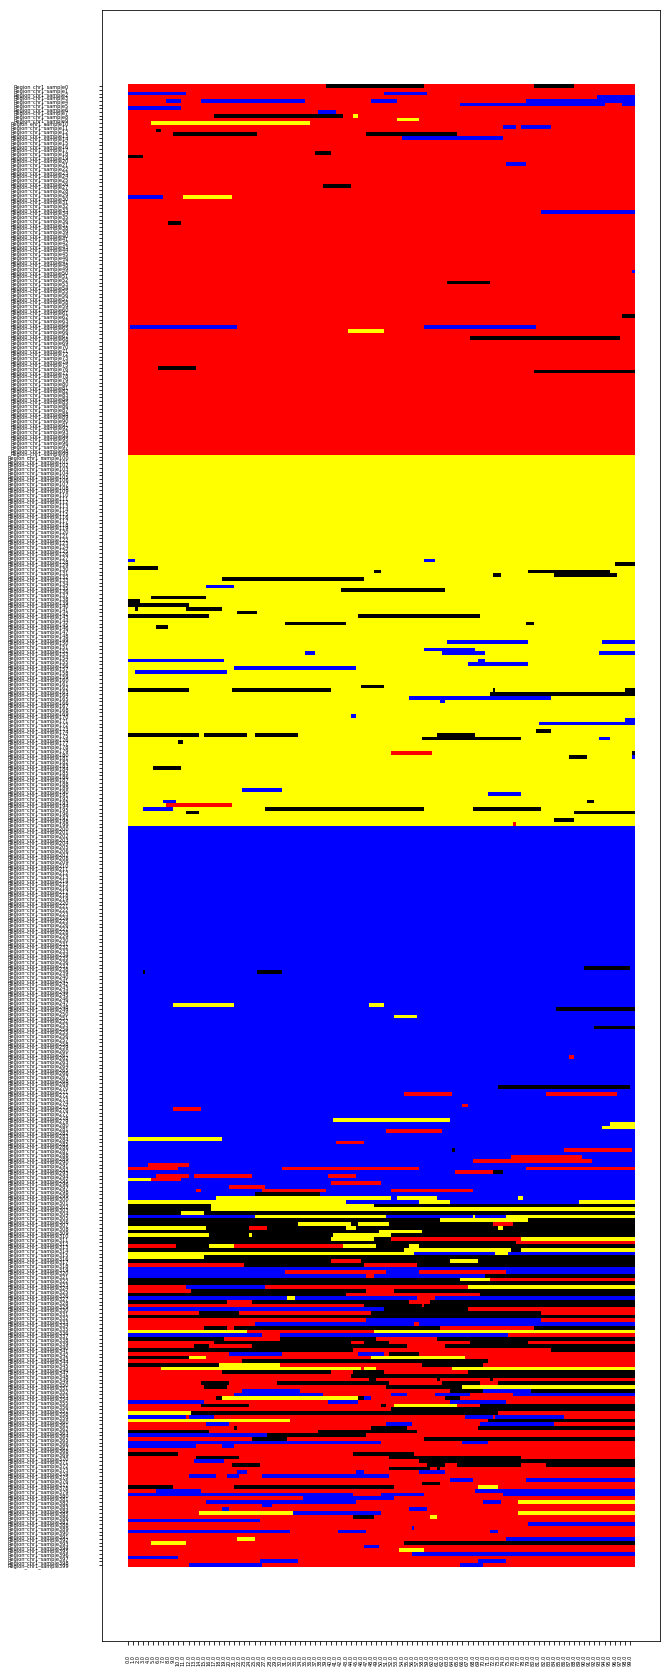

In [30]:
################
################        TRUTH

#### begin by compressing assignments by individuals. Lightens the load of the following plot.

from synth_tools.Ideogram_tools import compress_ideo, return_ideogram, chromosome_collections
import re

import re
chromosome_list= []
chromosomes= [Chr]

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_chr'+str(Chr)+ '_' + Subject for Chr in chromosomes])

ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list,Out)

ID= 'truth'

fig= return_ideogram(ideo, chromosome_list,ID)

#### C. KDE classification of local haplotypes.

Use distributions in PCA feature space of reference population samples to assign reference and non-reference accessions.

Kernel density estimation is used at each window to derive reference specific likelihoods. Proportion threshold and outlier threshold on respective cdfs used for assignment into **pure**, **intermediate** and **outlier** classses (**notebook 6** and notebook **13** for more detail on intermediate and outlier classifications).

- [6. A link to Fst](https://nbviewer.jupyter.org/github/SantosJGND/Genetic-data-analysis/blob/master/Notebooks/6.%20A%20link%20to%20FSTs.ipynb)
- [13. Outliers and genetic structure](https://nbviewer.jupyter.org/github/SantosJGND/Stats_Lab/blob/master/Notebooks/13.%20Outliers_genetic_structure.ipynb) 
focuses on the identification of samples from non-reference sources under different structure parameters ([Fig. 4](https://github.com/SantosJGND/Stats_Lab/blob/master/Complementary_data/Supplemental_Figure_S11.png)).

adding ideograms...


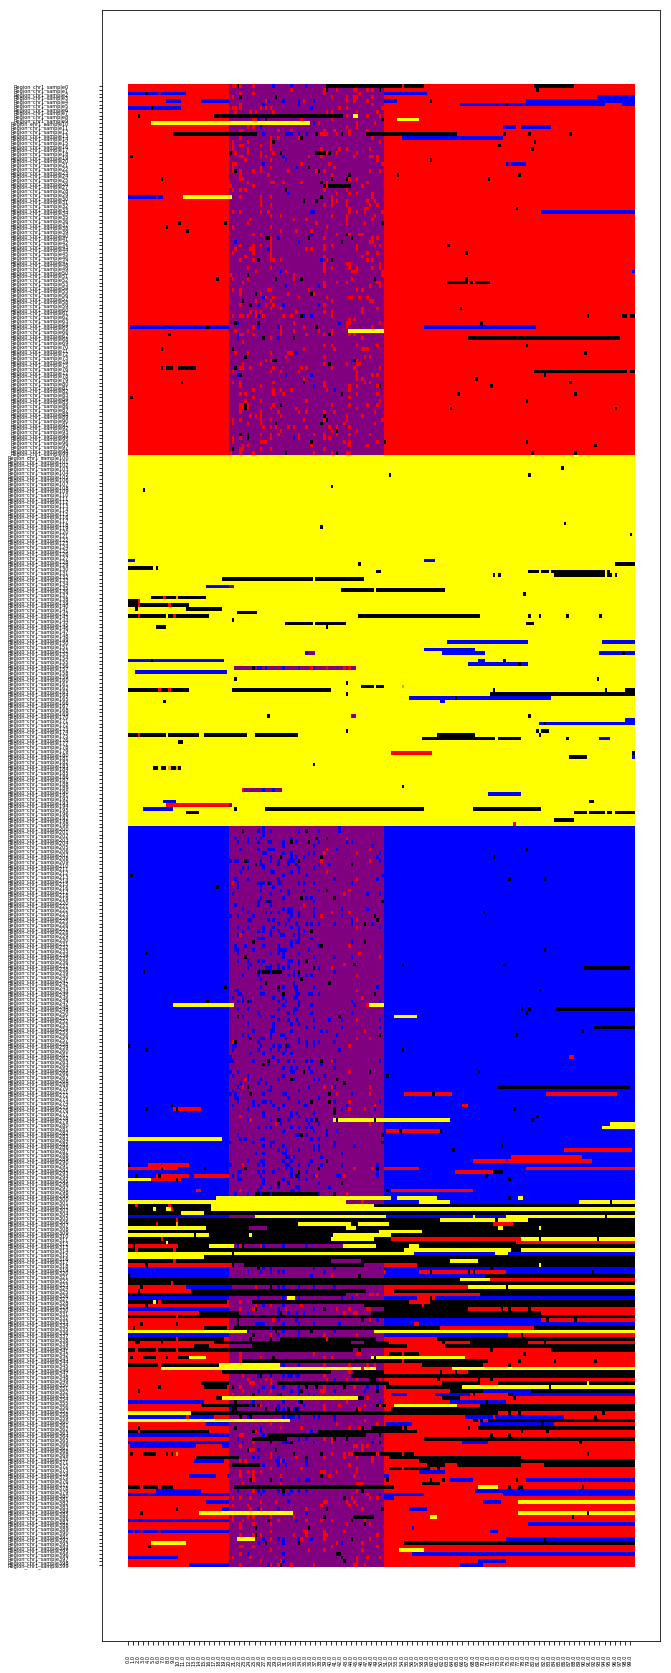

In [58]:
### KDE analysis across windows
from synth_tools.Sim_ideogram_tools import Merge_class, extract_profiles, KDE_windows

## Use known consistent representatives of genetic sources.
ref_labels= [0,1,2]
kde_class_labels= label_vector

## Use result of MS classification.
ref_labels= [0,1,2]
kde_class_labels= labels1

Comparison_threshold= 5
Outlier_threshold= 5e-3

color_ref= ['red','blue','yellow','black','purple','orange','green','silver','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

KDE_windows(Windows,kde_class_labels,ref_labels,Out,colors= 'alt',alt_col= color_ref,Comparison_threshold= Comparison_threshold,Outlier_threshold= Outlier_threshold)

The output of the application of this classification method to real data is unfortunately much less neat. 

- [Ideogram cut](

### VI. Output Simulated Data

#### A. Lamp Output


In [ ]:
### Write LAMP-file

Refs= [0,1,2]
Admx= [3]
Home= 'LAMP-HAP_test'


def lamp_input(Out, Refs, Admx, haplotypes, Home):
    
    Snps= [np.linspace(x,Out[1][x],L) for x in Out[1].keys()]
    Snps= [int(x) for x in it.chain(*Snps)]
    
    filename= Home + "/test_lamp.pos"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    posfile= open(filename,'w')
    for s in sorted(Snps):
        posfile.write(str(s) + '\n')
    posfile.close()
    
    for pop in Refs:
        filename= Home + "/pop{}.ref".format(pop)
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        Output= open(filename,'w')
        for acc in label_indicies[pop]:
            Output.write(''.join([str(x) for x in haplotypes[Whose[acc]]]) + '\n')
        Output.close()
    
    for pop in Admx:
        filename= Home + "/pop{}.txt".format(pop)
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        Output= open(filename,'w')
        for acc in label_indicies[pop]:
            Output.write(''.join([str(x*2) for x in haplotypes[Whose[acc]]]) + '\n')
        Output.close()

import os
lamp_input(Out,Refs,Admx,haplotypes,Home)

#### B. Geno and plink output. KDE_Galaxy format

In [ ]:
Refs= [0,1,2]
Admx= [3]
Home= 'LAMP-HAP_test'


def kde_input(Out, Refs, Admx, haplotypes, Home):
    
    Snps= [np.linspace(x,Out[1][x],L) for x in Out[1].keys()]
    Snps= [int(x) for x in it.chain(*Snps)]
    
    filename= Home + "/test_markers.txt"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    posfile= open(filename,'w')
    for s in sorted(Snps):
        posfile.write(str(chromosomes[0]) + '\t' + '\t'.join(['0']*2) + '\t' + str(s) + '\tA\tC\t' + '\n')
    posfile.close()
    
    ## geno file
    Geno_out= 'kde_test.geno'
    os.makedirs(os.path.dirname(Geno_out), exist_ok=True)
    Geno_out= open(Geno_out,'w')
    
    ## reference index file
    ref_file= Home + "/test_ref.txt"
    os.makedirs(os.path.dirname(ref_file), exist_ok=True)
    Output_ref= open(ref_file,'w')
    
    ## admixed index file
    admx_file= Home + "/test_admx.txt"
    os.makedirs(os.path.dirname(admx_file), exist_ok=True)
    Output_admx= open(admx_file,'w')
    
    ## fam file
    fam_file= Home + '/kde_test.fam'
    os.makedirs(os.path.dirname(admx_file), exist_ok=True)
    Output_admx= open(admx_file,'w')
    
    d= 0
    
    for pop in Refs:
        
        for acc in label_indicies[pop]:
            ## write to geno
            Geno_out.write(''.join([str(x) for x in haplotypes[Whose[acc]]]) + '\n')
        Output.close()
    
    for pop in Admx:
        
        for acc in label_indicies[pop]:
            Geno_out.write(''.join([str(x*2) for x in haplotypes[Whose[acc]]]) + '\n')
        Output.close()




### C. Loter

The software *Loter* (Dias-Alves et al. 2018) provides a python interface and a [jupyter tutorial](https://github.com/bcm-uga/Loter). 

I have not run this on this particular data because i am.. running Windows. 

In [ ]:

#### Loter requires pure individuals, so we'll draw extract 20 from each reference group to 
#### serve as reference (train) and use the rest as admx (test) in loter.
Ref_sample= 20

sample1= [x for x in Whose if label_vector[x] == 0]
sample1= sample(sample1,Ref_sample)

sample2= [x for x in Whose if label_vector[x] == 1]
sample2= sample(sample2,Ref_sample)

Gp1= np.array([haplotypes[x] for x in Whose if ind_to_group[x][0] == 0 and x not in sample1])
Gp2= np.array([haplotypes[x] for x in Whose if ind_to_group[x][0] == 1 and x not in sample2])

Admix_indexes= [x for x in Whose if x in sample1 or x in sample2 or label_vector[x] == 2]
All= np.array([haplotypes[x] for x in Admix_indexes])



In [ ]:

########## LOTER
##########

Snps= [np.linspace(x,Out[1][x],L) for x in Out[1].keys()]
Snps= [int(x) for x in it.chain(*Snps)]
Snps= sorted(Snps)

import loter.locanc.local_ancestry as lc

res_loter= lc.loter_smooth([Gp1,Gp2],All)


def return_loter_blocks(loter_data,snps):
    '''
    Organise Loter ancestry assignment matrix into a Blocks type dictionary.
    '''
    loter_data= loter_data.T
    snp_count= 0
    Blocks= {}
    Out= {}
    
    current_snp= snps[0]
    current= loter_data[0,:]
    
    for x in range(1,loter_data.shape[0]):
        
        if sum(loter_data[x,:] != current) > 0: 
            Blocks[current_snp]= current
            Out[current_snp]= snps[x] - 1
            current_snp= snps[x]
            current= loter_data[x]
        if x == loter_data.shape[0]:
            Blocks[current_snp]= current
            Out[current_snp]= snps[x] - 1
    return Blocks, Out


loter_blocks, loter_out= return_loter_blocks(res_loter,Snps)

loter_blocks= {1:loter_blocks}
loter_out= {1:loter_out}

Ideo_loter = []
chromosome_list= []
chromosomes= loter_blocks.keys()

for here in range(len(Admix_indexes)):
    Subject = 'sample' + str(Admix_indexes[here])
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,loter_out[Chr][bl],color_ref[loter_blocks[Chr][bl][here]]] for bl in sorted(loter_blocks[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo_loter.extend(Stock)

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo_loter = pd.DataFrame(Ideo_loter,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo_loter = ideo_loter[ideo_loter.chrom.apply(lambda x: x in chromosome_list)]

ideo_loter = compress_ideo(ideo_loter,loter_out,chromosome_list)

fig= return_ideogram(ideo_loter)

